In [25]:
import credentials as cr
import SQL_requests as rq
import pandas as pd
from spotify_api import Spotify_api
from db_connect import Db_connect
from recommendation_system import Recommendation

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Application parameters

In [27]:
# redirect_uri = 'http://localhost/'
data_path = cr.DATA_PATH

sp = Spotify_api()
db = Db_connect()
rc = Recommendation()

## Get datas using Spotify API  
I get my personnal spotify datas using spotify api and spotify_api.py class. The Pandas dataframes created are converted into csv files which will be used to create the sqlite database.

In [3]:
playlists_df = sp.get_playlists_with_tracks()

features_df = sp.get_playlist_features(playlists_df)
features_df.drop_duplicates(inplace=True)

tracks_df = sp.get_tracks(features_df)

contains_df = sp.get_contains(playlists_df)

playlists_df.to_csv(data_path + 'playlists.csv', encoding='utf-8')
features_df.to_csv(data_path + 'features.csv', encoding='utf-8')
tracks_df.to_csv(data_path + 'tracks.csv', encoding='utf-8')
contains_df.to_csv(data_path + 'contains.csv', encoding='utf-8', index=False)

Found playlists :  28
Pop/rock kings & queens
Autoportrait
Arcades & Neons
(RPG) Leon Petersen - Don't Piss Me Off
Feel good
(RPG) Scarface - Heavy Dirty Soul
Girl Power
Alternative/Psychedelic
Musique classique
(RPG) Ashton Butler - Punkin' Shakespeare
Badass Metal
(RPG) Spooky Unicorns - Rock'N Monsters
Old Time Rock'N Roll (Kurty's playlist)
Skate It !
Favoris
Horror Circus
Ballads & Slows
(RPG) Robyn Thorn - Rockin' Girl
Top 30
(RPG) Kurt Hayward - Punk Ass
(RPG) Zak Winterscar - Broken Soldier
Accoustic
Modern Pop/Rock
Classic Rock
Ol'Retro Mood (50/60's)
Deadshot
Red Hood
Nightwing


## DataBase connect and creation

Create the SQLite database, create or update the tables with spotify datas (playlist, feature, track).

In [13]:
db.init_connection()
db.create_tables([rq.CREATE_PLAYLIST, rq.CREATE_TRACK, rq.CREATE_TRACK_FEATURES, rq.CREATE_CONTAINS])
db.insert_data(rq.INSERT_PLAYLISTS, data_path + 'playlists.csv')
db.insert_data(rq.INSERT_TRACKS_FEATURES, data_path + 'features.csv')
db.insert_data(rq.INSERT_TRACKS, data_path + 'tracks.csv')
db.insert_data(rq.INSERT_CONTAINS, data_path + 'contains.csv')
db.close_connection()

## Developping the algorithm

I start by getting the 'Top 30' (6AsIwsN6mH7dQSChLsqSlY) playlist from the database, which will be used to developp and test the algorithm.  
Let's get the first try and view the results.

In [3]:
db.init_connection()
top_30_features = pd.read_sql_query(rq.SELECT_PLAYLIST + "'6AsIwsN6mH7dQSChLsqSlY'", db.connector).set_index('id')
top_30_titles = pd.read_sql_query(rq.SELECT_PLAYLIST_TITLES + "'6AsIwsN6mH7dQSChLsqSlY'", db.connector).set_index('id')
track_titles = pd.read_sql_query(rq.SELECT_TRACKS_TITLES, db.connector).set_index('id')
track_features = pd.read_sql_query(rq.SELECT_TRACKS_FEATURES, db.connector).set_index('id')
db.close_connection()

### Vizualisation of the targetted playlist :

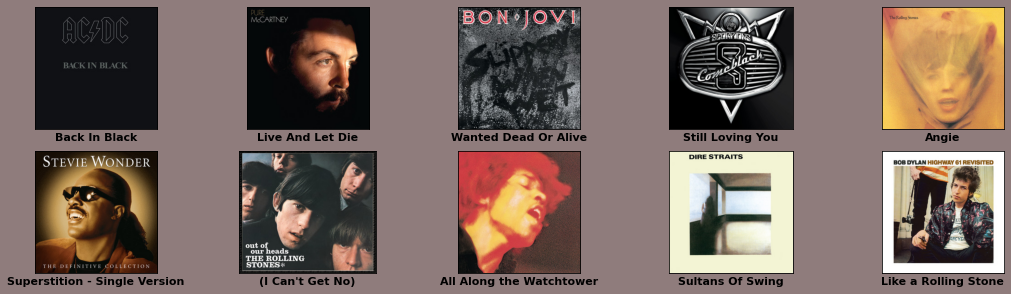

In [28]:
rc.visualize_cover(top_30_titles.head(10))

### Content-Based Recommender

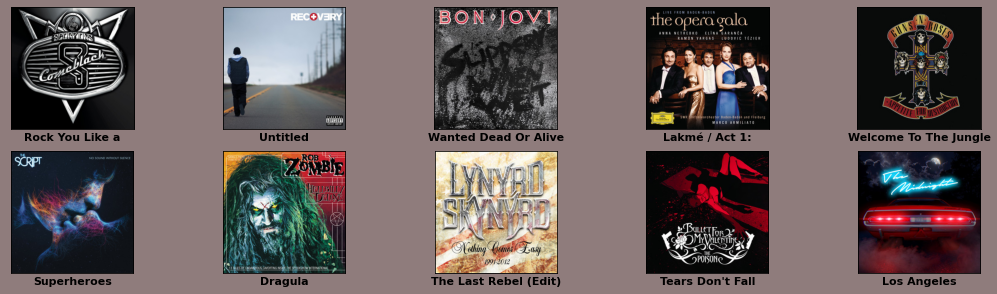

In [65]:
from sklearn.neighbors import NearestNeighbors


neigh = NearestNeighbors(n_neighbors=5, algorithm='auto')

neigh.fit(track_features)

predict = neigh.kneighbors(top_30_features, 2, return_distance=False)

keys = []

for element in predict:
    index = track_features.iloc[element[1]].name
    if index not in top_30_titles.index:
        if index not in keys:
            keys.append(track_features.iloc[element[1]].name)

reco = track_titles.loc[keys]

rc.visualize_cover(reco.head(10))



In [22]:
#creating the playlist dataframe with extended features using Spotify data
# def generate_playlist_df(playlist_name, playlist_dic, spotify_data):
    
#     playlist = pd.DataFrame()

#     for i, j in enumerate(sp.playlist(playlist_dic[playlist_name])['tracks']['items']):
#         playlist.loc[i, 'artist'] = j['track']['artists'][0]['name']
#         playlist.loc[i, 'track_name'] = j['track']['name']
#         playlist.loc[i, 'track_id'] = j['track']['id']
#         playlist.loc[i, 'url'] = j['track']['album']['images'][1]['url']
#         playlist.loc[i, 'date_added'] = j['added_at']

#     playlist['date_added'] = pd.to_datetime(playlist['date_added'])  
    
#     playlist = playlist[playlist['track_id'].isin(spotify_data['track_id'].values)].sort_values('date_added',ascending = False)

#     return playlist

    
def generate_recommendation(spotify_data, playlist_vector, nonplaylist_df):

    non_playlist = spotify_data[spotify_data['track_id'].isin(nonplaylist_df['track_id'].values)]
    non_playlist['sim'] = cosine_similarity(nonplaylist_df.drop(['track_id'], axis = 1).values, playlist_vector.drop(labels = 'track_id').values.reshape(1, -1))[:,0]
    non_playlist_top15 = non_playlist.sort_values('sim',ascending = False).head(5)
    non_playlist_top15['url'] = non_playlist_top15['track_id'].apply(lambda x: sp.track(x)['album']['images'][1]['url'])
    
    return  non_playlist_top15

def generate_playlist_vector(spotify_features, playlist_df, weight_factor):
    
    spotify_features_playlist = spotify_features[spotify_features['id'].isin(playlist_df['id'].values)]
    spotify_features_playlist = spotify_features_playlist.merge(playlist_df[['id']], on = 'id', how = 'inner')
    
    spotify_features_nonplaylist = spotify_features[~spotify_features['id'].isin(playlist_df['id'].values)]
    
    playlist_feature_set = spotify_features_playlist

    playlist_feature_set['weight'] = playlist_feature_set['days_from_recent'].apply(lambda x: weight_factor ** (-x))
    
    playlist_feature_set_weighted = playlist_feature_set.copy()
    
    playlist_feature_set_weighted.update(playlist_feature_set_weighted.iloc[:,:-3].mul(playlist_feature_set_weighted.weight.astype(int),0))   
    
    playlist_feature_set_weighted_final = playlist_feature_set_weighted.iloc[:, :-3]
    

    
    return playlist_feature_set_weighted_final.sum(axis = 0), spotify_features_nonplaylist

  

In [ ]:
  
# playlist_df = generate_playlist_df('MixedMood', playlist_dic, spotify_data)  #top30_titles

scaled_features = MinMaxScaler().fit_transform([
  track_features['acousticness'].values,
  track_features['danceability'].values,
  track_features['duration_ms'].values,
  track_features['energy'].values,
  track_features['instrumentalness'].values,
  track_features['liveness'].values,
  track_features['loudness'].values,
  track_features['speechiness'].values,
  track_features['tempo'].values,
  track_features['valence'].values,
  ])

#Storing the transformed column vectors into our dataframe
track_features[['acousticness','danceability','duration_ms','energy','instrumentalness','liveness','loudness','speechiness','tempo','valence']] = scaled_features.T

playlist_vector, nonplaylist_df = generate_playlist_vector(track_features, top_30_titles, 1.2)
print(playlist_vector.shape)
print(nonplaylist_df.head())

recommendation = generate_recommendation(track_features, playlist_vector, nonplaylist_df)  
recommendation.head()
